# Unit 6. Essential Deep Learning Tips & Tricks

# Exercise 2: Decreasing Overfitting with Weight Decay

In [ ]:
!pip install seaborn

In [1]:
%load_ext watermark
%watermark -p torch,lightning

torch    : 2.1.2+cu121
lightning: 2.1.4



In [2]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, PyTorchMLP

In [3]:
num_epochs = 100

In [4]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, cosine_t_max, weight_decay=0.01):
        super().__init__()

        self.learning_rate = learning_rate
        self.cosine_t_max = cosine_t_max
        self.model = model
        self.weight_decay = weight_decay

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        
        ##################################################################################
        ### YOUR TASK: Replace Adam with AdamW and experiment with the weight_decay param
        ##################################################################################
        
        opt = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.cosine_t_max)

        return [opt], [sch]

Laziest way to test different weight decays is to sweep across different values and train different models

In [ ]:
L.seed_everything(123)
dm = CustomDataModule()

data_dict = {}

for wd in [0.0, 0.01, 0.05, 0.1]:

    data_dict[wd] = {}

    pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.005,
                                    cosine_t_max=num_epochs, weight_decay=wd)

    trainer = L.Trainer(
        max_epochs=num_epochs,
        accelerator="cpu",
        devices="auto",
        logger=CSVLogger(save_dir="logs/", name=f"my-model_{wd}"),
        deterministic=True,
    )
    # Ideally we would supress all the output messages from the trainer
    trainer.fit(model=lightning_model, datamodule=dm)

    data_dict[wd]["logs"] = f"{trainer.logger.log_dir}/metrics.csv"
    data_dict[wd]["test_accuracy"] = trainer.test(model=lightning_model, datamodule=dm)[0]

In [6]:
data_dict

{0.0: {'logs': 'logs/my-model_0.0/version_0/metrics.csv',
  'test_accuracy': {'test_acc': 0.8847500085830688}},
 0.01: {'logs': 'logs/my-model_0.01/version_0/metrics.csv',
  'test_accuracy': {'test_acc': 0.8822500109672546}},
 0.05: {'logs': 'logs/my-model_0.05/version_0/metrics.csv',
  'test_accuracy': {'test_acc': 0.9010000228881836}},
 0.1: {'logs': 'logs/my-model_0.1/version_0/metrics.csv',
  'test_accuracy': {'test_acc': 0.8952500224113464}}}

In [7]:
import pandas as pd

In [14]:
results_df_list = []

for wd, data in data_dict.items():

    temp_df = (pd.read_csv(data["logs"])
                .drop(columns=["step"])
                .groupby("epoch")
                .mean()
                .reset_index()
                .assign(weight_decay=wd)
                )
    
    results_df_list.append(temp_df)

results_df = pd.concat(results_df_list, ignore_index=True)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

It seems that higher weight decay values yield worse loss performance on training data, but a better overall performance on the validation set. This comes at the cost of a slower convergence rate, which makes sense knowing that we are shrinking the model parameters.

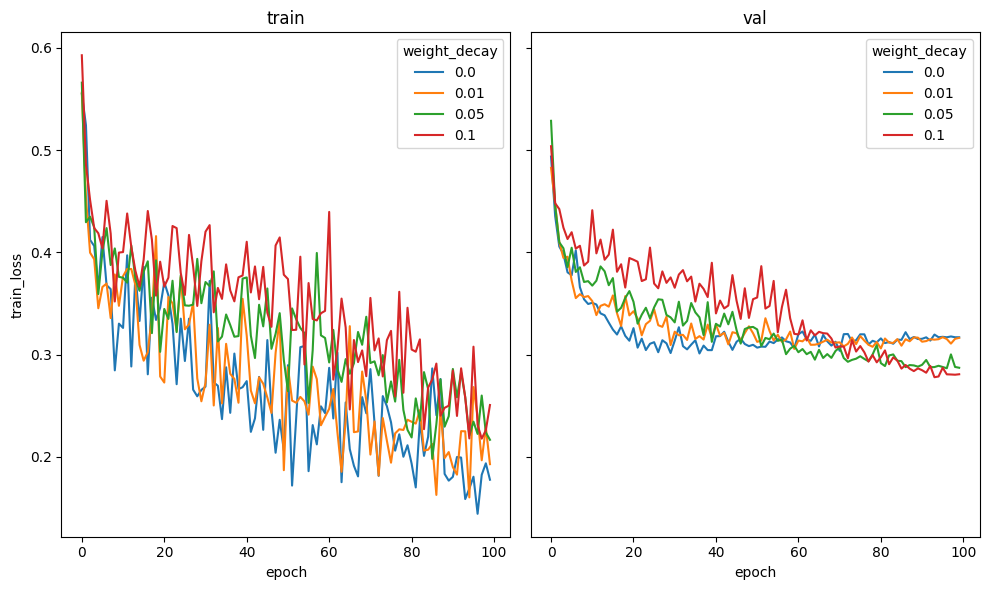

In [22]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10,6))

for ax, l in zip(axs, ["train", "val"]):

    sns.lineplot(x="epoch", y=f"{l}_loss", hue="weight_decay", palette="tab10", data=results_df, ax=ax)
    ax.set_title(l)

plt.tight_layout()
plt.show()

The same can be said regarding the accuracy, with the models with higher weight decay being slightly better

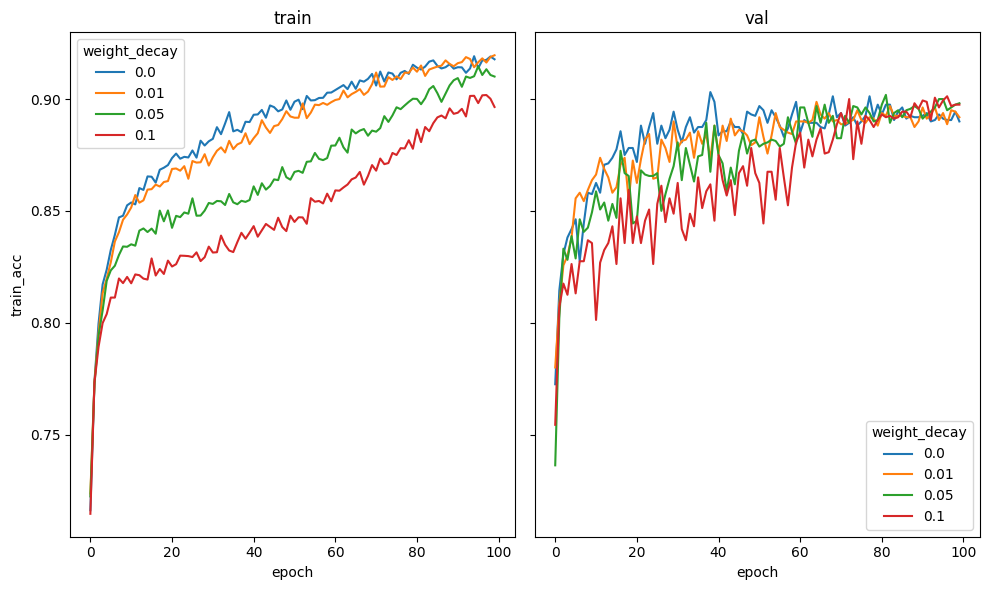

In [23]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10,6))

for ax, l in zip(axs, ["train", "val"]):

    sns.lineplot(x="epoch", y=f"{l}_acc", hue="weight_decay", palette="tab10", data=results_df, ax=ax)
    ax.set_title(l)

plt.tight_layout()
plt.show()

On the final, unseen, test data, using a wight decay of `0.05` has a slight edge of the next value of `0.1`

In [27]:
for wd, data in data_dict.items():

    print(f"WD {wd} test accuracy: {data['test_accuracy']['test_acc']:.4f}")

WD 0.0 test accuracy: 0.8848
WD 0.01 test accuracy: 0.8823
WD 0.05 test accuracy: 0.9010
WD 0.1 test accuracy: 0.8953
